In [1]:
import pandas as pd
import collections
import numpy as np
from tqdm.notebook import tqdm, trange
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from IPython.display import Image
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

# A simpler version of the Two-tower Model

[Sampling-Bias-Corrected Neural Modeling for Large Corpus
Item Recommendations](https://research.google/pubs/pub48840/)


# Goal

**Given user information and movie information, predict how would the user rate the moive (1-5).**

# Metric

**RMSE**

# Feature description
There are categorical features (C) and dense features (D). For each categorical feature, I create an embedding layer. Alternatively, for genres, each movie can have more than one genre. So it a bag of categorical feature. I create an create an embeddingbag layer for it. 

For each table, avaiable information includes:

user table:  
- userID (C)
- gender (C)
- age (D)
- occupation (C)
- zip (not used)
- history (generated) according to the timestamp in the rating table, record user's watch history. Only keeping the last 20 movieids for effciency purpose.

moive table:  
- movieID (C)
- title (not used)
- genres (bag of C)

rating table:  
- userID (C)  foreign key to user.userID
- movieID (C)  foreign key to moive.movieID
- rating (D)  target variable
- time (used to generate history)


# Model structure

Difference from the original paper:
- Regression rather than classification 
- Sampling bias doesn't apply, if not use in batch negative samples


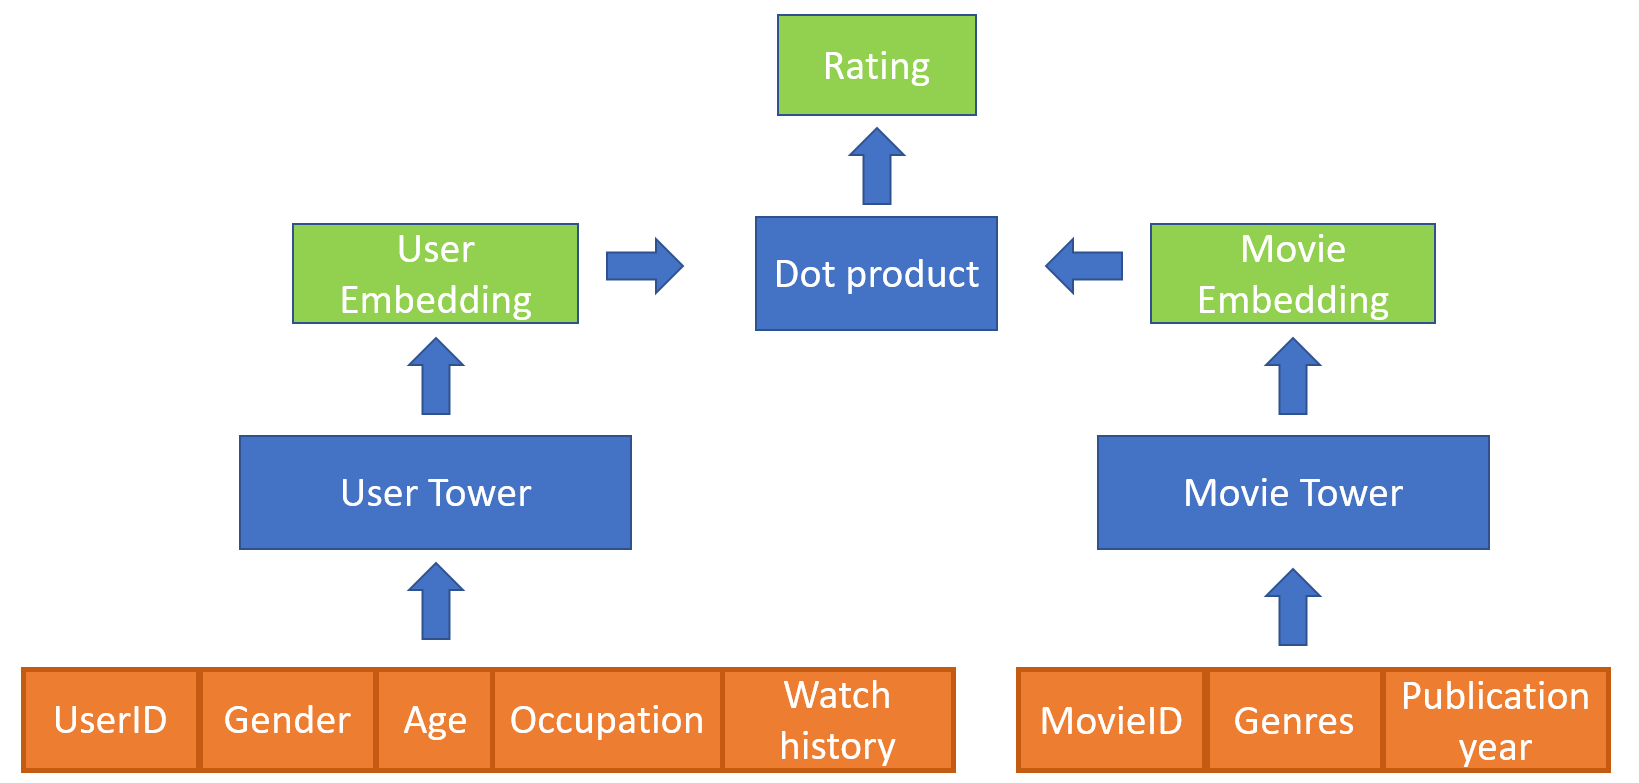

In [3]:
Image(filename='two-tower-model-structure.png') 

# Data loading and transformations

In [4]:
df_user = pd.read_csv('./ml-1m/users.dat', sep='::', engine = 'python', names=['userid', 'gender', 'age', 'occupation', 'zip'], header=None)
df_movie = pd.read_csv('./ml-1m/movies.dat', sep='::', engine = 'python', names=['movieid', 'title', 'genres'], header=None, encoding = "ISO-8859-1")
df_rating = pd.read_csv('./ml-1m/ratings.dat', sep='::', engine = 'python', names=['userid', 'movieid', 'rating', 'time'], header=None)


In [5]:
df_user.head(2)

,userid,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072


In [6]:
df_movie.head(2)

,movieid,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy


In [7]:
df_rating.head(2)

,userid,movieid,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109


In [8]:
# transform df_user['age'] between 0 and 1
age = df_user['age'].values.reshape(-1,1)
scaler = preprocessing.MinMaxScaler() 
scaled_age = scaler.fit_transform(age)
df_user['age'] = scaled_age

In [9]:
def toCategoricalId(df, column):
    le = preprocessing.LabelEncoder()
    df[column+'id'] = le.fit_transform(df[column])
    return le

In [10]:
# process other columns in df_user
toCategoricalId(df_user, 'userid')
toCategoricalId(df_user, 'gender')
toCategoricalId(df_user, 'occupation')


LabelEncoder()

In [11]:
# process df_movie['genres'] column
# the genres column is special. 
# Each movie has at least 1 genre and at most 6 (in this particular dataset).
# Either pick the first genre or make it a list of genres and take average genre embedding.
le = preprocessing.LabelEncoder()
le.fit([item for sublist in df_movie['genres'].str.split('|') for item in sublist])
genresids = []
for genres in df_movie['genres'].str.split('|'):
    genresids.append(le.transform(genres).tolist())
df_movie['genresids'] = genresids

In [12]:
num_genres=len(le.classes_)
num_genres

18

In [13]:
# process df_movie['title'] column
# I notice the title always comes with the release year, which is also helpful information
name_and_year = df_movie['title'].str.findall(r'(.*)\((.*)\)').map(lambda x: list(x[0]))
name_and_year = np.array(name_and_year.values.tolist())
df_movie['puretitle'] = name_and_year[:,0]
df_movie['year'] = name_and_year[:,1]
df_movie['year'] = df_movie['year'].map(int)

year = df_movie['year'].values.reshape(-1,1)
scaler = preprocessing.MinMaxScaler() 
scaled_year = scaler.fit_transform(year)
df_movie['year'] = scaled_year

In [14]:
le = toCategoricalId(df_movie, 'movieid') # use the same le to transform movieid
df_rating['movieid'+'id'] = le.transform(df_rating['movieid'])

In [15]:
# sort by time
df_rating = df_rating.sort_values(by=['userid','time'])
df_rating = df_rating.reset_index(drop=True)

In [16]:
histories = []
curr_user = -1
curr_history = []
for i in trange(len(df_rating)):
    row = df_rating.iloc[i]
    histories.append(curr_history)
    if curr_user != row['userid']:
        curr_user = row['userid']
        curr_history = []
    curr_history = curr_history.copy()
    curr_history.append(row['movieidid'])

df_rating['history'] = histories

  0%|          | 0/1000209 [00:00<?, ?it/s]

In [17]:
df_rating.head(5)

,userid,movieid,rating,time,movieidid,history
0,1,3186,4,978300019,3117,[]
1,1,1270,5,978300055,1250,[3117]
2,1,1721,4,978300055,1672,"[3117, 1250]"
3,1,1022,5,978300055,1009,"[3117, 1250, 1672]"
4,1,2340,3,978300103,2271,"[3117, 1250, 1672, 1009]"


In [18]:
# merge together

df = pd.merge(pd.merge(df_rating, df_user, on=['userid']), df_movie, on=['movieid'])
df.drop(columns=['userid','movieid', 'gender', 'occupation', 'zip', 'genres', 'time', 'title'], inplace=True)
# transform ratings into the range of [0,1]
# df['rating'] = df['rating'].map(lambda x: (x-1.)/4.)
# transform ratings into the range of [-1,1]
# df['rating'] = df['rating'].map(lambda x: (x-3.)/2.)

In [19]:
df = df.drop(columns=['movieidid_y'])
df = df.rename(columns={"movieidid_x": "movieidid"})

In [20]:
df.head(3)

,rating,movieidid,history,age,useridid,genderid,occupationid,genresids,puretitle,year
0,4,3117,[],0.000000,0,0,10,[7],"Girl, Interrupted",0.987654
1,4,3117,"[1192, 109, 896, 3412, 1533, 476, 585, 389, 19...",0.436364,7,1,12,[7],"Girl, Interrupted",0.987654
2,3,3117,"[3032, 523, 1668, 3327, 2748, 1192, 1178, 1207...",0.800000,32,1,3,[7],"Girl, Interrupted",0.987654


In [21]:
# df.to_csv('combined.csv')

In [22]:
num_gender = df['genderid'].max() + 1
num_user = df['useridid'].max() + 1
num_occupation= df['occupationid'].max() + 1
num_movie = df['movieidid'].max() + 1
num_ratings = len(df)

In [23]:
num_gender, num_user, num_occupation, num_movie, num_genres, num_ratings

(2, 6040, 21, 3883, 18, 1000209)

# Train/test split, customize dataset and dataloader

In [24]:
# 0.8, 0.2 split
train_df=df.sample(frac=0.8) 
test_df=df.drop(train_df.index)

In [25]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data = self.X.iloc[idx].to_dict()
        label = self.Y.iloc[idx]
        return data, label

In [26]:
# a helper function for collate_fn used in DataLoader
# this function convert list into torch.Tensor and also move it to target device
# it also pads 'num_genres' to make genresids a valid tensor. 'num_genres' will be skipped in the EmbeddingBag layer
def df2pt(dic):
    for k in dic:
        if k == 'genresids':
            batch = dic[k]
            max_cols = max([len(row[-20:]) for row in batch])
            padded = []
            for i in range(len(batch)):
                padded.append( batch[i][-20:] + [num_genres]*(max_cols-len(batch[i][-20:])))
            dic[k] = torch.LongTensor(padded).to(device)
        elif  k =='history':
            batch = dic[k]
            max_cols = max([len(row[-20:]) for row in batch])
            padded = []
            for i in range(len(batch)):
                padded.append( batch[i][-20:] + [num_movie]*(max_cols-len(batch[i][-20:])))
            dic[k] = torch.LongTensor(padded).to(device)
        elif 'id' in k:
            dic[k] = torch.LongTensor(dic[k]).unsqueeze(0).T.to(device)
        else:
            dic[k] = torch.Tensor([dic[k]]).T.to(device)
    return dic

In [27]:
# self define how to load each batch
def collate_fn(batch):
    batch_size = len(batch)
    batch_X = collections.defaultdict(list)
    batch_Y = []
    
    for i in range(batch_size):
        data, label = batch[i]
        for key in data:
            batch_X[key].append(data[key])
        batch_Y.append(label)
    batch_X = df2pt(batch_X)
    batch_Y = torch.Tensor(batch_Y).to(device)
    return batch_X, batch_Y


In [28]:
batch_size = 256

In [29]:
# train_dataset and train_dataloader
# X = train_df.drop(columns=['rating']) # title can be put into bert and get a feature vector
X = train_df.drop(columns=['rating','puretitle'])
Y = train_df['rating']
train_dataset = CustomDataset(X,Y)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


In [30]:
# test_dataset and test_dataloader
# test_X = test_df.drop(columns=['rating']) # title can be put into bert and get a feature vector
test_X = test_df.drop(columns=['rating','puretitle'])
test_Y = test_df['rating']
test_dataset = CustomDataset(test_X,test_Y)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


# model 

In [31]:
class TwoTower(nn.Module):
    def __init__(self, fclayers = 2, activation = 'relu'):
        super().__init__()
        assert fclayers in [1,2], 'fclayers not implemented'
        self.fclayers = fclayers
        assert activation in ['relu','tanh', 'sigmoid'], 'activation not implemented'
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.Sigmoid()
        
        # user tower
        self.userid_emb_layer = nn.Embedding(num_user,100)
        self.gender_emb_layer = nn.Embedding(num_gender,2)        
        self.age_layer = nn.Linear(1,1)        
        self.occupation_emb_layer = nn.Embedding(num_occupation,4) 
        self.user_fc1 = nn.Linear(207, 64) # 100 + 2 + 1 + 4 + 100
        self.user_fc2 = nn.Linear(64, 32)
        
        # shared layer
        self.movieid_emb_layer = nn.EmbeddingBag(num_movie+1,100, padding_idx=num_movie)
        
        # movie tower
        self.genre_emb_layer = nn.EmbeddingBag(num_genres+1, 4, mode = 'mean', padding_idx=num_genres)
        self.year_layer = nn.Linear(1,1)
        self.movie_fc1 = nn.Linear(105, 64)
        self.movie_fc2 = nn.Linear(64, 32)
        
    def forward(self, useridid, genderid, age, history, occupationid, genresids, movieidid, year):
        batch_size = useridid.size(0)
        
        # user infos
        userid_emb = self.userid_emb_layer(useridid).squeeze(1)
        gender_emb = self.gender_emb_layer(genderid).squeeze(1)
        age_emb = self.age_layer(age)     
        occupation_emb = self.occupation_emb_layer(occupationid).squeeze(1)
        history_emb = self.movieid_emb_layer(history)
        
        user_emb = torch.cat((userid_emb, gender_emb, age_emb, occupation_emb, history_emb), -1)
        
        # movie infos
        movieid_emb = self.movieid_emb_layer(movieidid)
        genre_emb = self.genre_emb_layer(genresids)
        year_emb = self.year_layer(year)
        
        movie_emb = torch.cat((movieid_emb, genre_emb, year_emb), -1)
        
        if self.fclayers == 2:
            user_emb = self.activation(self.user_fc1(user_emb))
            user_emb = self.activation(self.user_fc2(user_emb))
            movie_emb = self.activation(self.movie_fc1(movie_emb))
            movie_emb = self.activation(self.movie_fc2(movie_emb))
        elif self.fclayers == 1:
            user_emb = self.activation(self.user_fc1(user_emb))
            movie_emb = self.activation(self.movie_fc1(movie_emb))
        else:
            user_emb = self.activation(user_emb)
            movie_emb = self.activation(movie_emb)

        out = torch.sum(user_emb*movie_emb, -1)
        out = torch.relu(out)
        return out       

In [32]:
twotower = TwoTower(fclayers = 2, activation = 'relu')
twotower = twotower.to(device)

In [33]:
num_epochs = 3
loss_fn = nn.MSELoss()
optimizer = optim.SGD(twotower.parameters(), lr=0.03, momentum=0.03, weight_decay=0.01)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.03, epochs = num_epochs, steps_per_epoch = 3126)

In [34]:
def test():
    twotower.eval()
    test_loss = 0
    test_size = 0
    for j_batch, test_batch in enumerate(test_dataloader):
        data, label = test_batch
        y_pred = twotower(**data)
        loss = loss_fn(y_pred, label)
        if not torch.isnan(loss):
            test_loss += loss * len(label)
            test_size += len(label)
    avg_test_loss = torch.sqrt(test_loss / test_size)
    twotower.train()
    return avg_test_loss

In [35]:
train_losses = []
test_losses = []
for i_epoch in range(num_epochs):
    for i_batch, sample_batched in enumerate(train_dataloader):
        data, label = sample_batched
        y_pred = twotower(**data)
        loss = torch.sqrt(loss_fn(y_pred, label))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if i_batch%500 == 0:
            avg_test_loss = test()
            print(f'epoch: {i_epoch}/{num_epochs}, iter: {i_batch}/{len(train_dataloader)}, tr_loss: {loss}, ts_loss: {avg_test_loss}')   
            train_losses.append(loss.item())
            test_losses.append(avg_test_loss.item())

epoch: 0/3, iter: 0/3126, tr_loss: 3.5317726135253906, ts_loss: 3.5516767501831055
epoch: 0/3, iter: 500/3126, tr_loss: 1.0923396348953247, ts_loss: 1.0586862564086914
epoch: 0/3, iter: 1000/3126, tr_loss: 1.0417044162750244, ts_loss: 1.0214803218841553
epoch: 0/3, iter: 1500/3126, tr_loss: 0.980204701423645, ts_loss: 1.0232963562011719
epoch: 0/3, iter: 2000/3126, tr_loss: 1.0362205505371094, ts_loss: 1.045060396194458
epoch: 0/3, iter: 2500/3126, tr_loss: 1.075947642326355, ts_loss: 1.0288804769515991
epoch: 0/3, iter: 3000/3126, tr_loss: 1.0054212808609009, ts_loss: 0.9955888390541077
epoch: 1/3, iter: 0/3126, tr_loss: 1.0266542434692383, ts_loss: 0.9991064071655273
epoch: 1/3, iter: 500/3126, tr_loss: 0.9842038750648499, ts_loss: 0.9819926023483276
epoch: 1/3, iter: 1000/3126, tr_loss: 0.9863094091415405, ts_loss: 1.0076004266738892
epoch: 1/3, iter: 1500/3126, tr_loss: 1.0225688219070435, ts_loss: 0.9635099172592163
epoch: 1/3, iter: 2000/3126, tr_loss: 1.0186673402786255, ts_loss

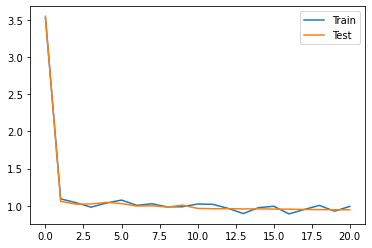

In [36]:
plt.plot(train_losses, label = 'Train')
plt.plot(test_losses, label = 'Test')
plt.legend()
plt.show()

# Discussion
It achieves 0.9450 RMSE on testset comparing to the best model on [paperwithcode](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-1m) reports 0.8227 RMSE. It seems that this model is not bad for my first try!

Training loss seems much more unstable than testing loss, because it's the train loss reports the average of a batch, while the test loss is averaged over entire testset.


# Improvement

- People may have personal rating preference. Movie may have bias, too. -> Model the hidden bias/preference.


In [45]:
class TwoTower2(nn.Module):
    def __init__(self, fclayers = 2, activation = 'relu', contrastive = None):
        super().__init__()
        assert fclayers in [1,2], 'fclayers not implemented'
        self.fclayers = fclayers
        assert activation in ['relu','tanh', 'sigmoid'], 'activation not implemented'
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=False)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        else:
            self.activation = nn.Sigmoid()
        self.contrastive = contrastive
        
        # user tower
        self.userid_emb_layer = nn.Embedding(num_user, 100)
        self.user_bias_layer = nn.Embedding(num_user, 1)
        self.gender_emb_layer = nn.Embedding(num_gender, 2)        
        self.age_layer = nn.Linear(1,1)        
        self.occupation_emb_layer = nn.Embedding(num_occupation,4) 
        self.user_fc1 = nn.Linear(207, 64) # 100 + 2 + 1 + 4 + 100
        self.user_fc2 = nn.Linear(64, 32)
        
        # shared layer
        self.movieid_emb_layer = nn.EmbeddingBag(num_movie+1,100, padding_idx=num_movie)
        
        # movie tower
        self.movie_bias_layer = nn.Embedding(num_movie, 1)
        self.genre_emb_layer = nn.EmbeddingBag(num_genres+1, 4, mode = 'mean', padding_idx=num_genres)
        self.year_layer = nn.Linear(1,1)
        self.movie_fc1 = nn.Linear(105, 64)
        self.movie_fc2 = nn.Linear(64, 32)
        if self.contrastive:
            self.dropout = torch.nn.Dropout(p=self.contrastive)
        
    def forward(self, useridid, genderid, age, history, occupationid, genresids, movieidid, year):
        batch_size = useridid.size(0)
        
        # user infos
        userid_emb = self.userid_emb_layer(useridid).squeeze(1)
        user_bias = self.user_bias_layer(useridid).squeeze(1)
        gender_emb = self.gender_emb_layer(genderid).squeeze(1)
        age_emb = self.age_layer(age)     
        occupation_emb = self.occupation_emb_layer(occupationid).squeeze(1)
        history_emb = self.movieid_emb_layer(history)
        
        user_emb = torch.cat((userid_emb, gender_emb, age_emb, occupation_emb, history_emb), -1)
        if self.contrastive:
            user_emb = self.dropout(user_emb)
            
        # movie infos
        movieid_emb = self.movieid_emb_layer(movieidid)
        movie_bias = self.movie_bias_layer(movieidid).squeeze(1)
        genre_emb = self.genre_emb_layer(genresids)
        year_emb = self.year_layer(year)
        
        movie_emb = torch.cat((movieid_emb, genre_emb, year_emb), -1)
        if self.contrastive:
            movie_emb = self.dropout(movie_emb)
            
        if self.fclayers == 2:
            user_emb = self.activation(self.user_fc1(user_emb))
            user_emb = self.activation(self.user_fc2(user_emb))
            movie_emb = self.activation(self.movie_fc1(movie_emb))
            movie_emb = self.activation(self.movie_fc2(movie_emb))
        elif self.fclayers == 1:
            user_emb = self.activation(self.user_fc1(user_emb))
            movie_emb = self.activation(self.movie_fc1(movie_emb))
        else:
            user_emb = self.activation(user_emb)
            movie_emb = self.activation(movie_emb)
        
        out = torch.sum(user_emb*movie_emb, -1) + user_bias.squeeze(1) + movie_bias.squeeze(1)
        out = self.activation(out)
        if self.contrastive: 
            return out, user_emb, movie_emb
        return out       

In [51]:
twotower2 = TwoTower2(fclayers = 2, activation = 'relu')
twotower2 = twotower2.to(device)

num_epochs = 3
loss_fn = nn.MSELoss()
optimizer2 = optim.SGD(twotower2.parameters(), lr=0.05, momentum=0.03, weight_decay=0.008)
scheduler2 = lr_scheduler.OneCycleLR(optimizer2, max_lr=0.05, epochs = num_epochs, steps_per_epoch = 3126)

In [52]:
def test2(model):
    model.eval()
    test_loss = 0
    test_size = 0
    for j_batch, test_batch in enumerate(test_dataloader):
        data, label = test_batch
        y_pred = model(**data)
        loss = loss_fn(y_pred, label)
        if not torch.isnan(loss):
            test_loss += loss * len(label)
            test_size += len(label)
    avg_test_loss = torch.sqrt(test_loss / test_size)
    model.train()
    return avg_test_loss

In [53]:
train_losses = []
test_losses = []
for i_epoch in range(num_epochs):
    for i_batch, sample_batched in enumerate(train_dataloader):
        data, label = sample_batched
        optimizer2.zero_grad()
        y_pred = twotower2(**data)
        loss = torch.sqrt(loss_fn(y_pred, label))
        loss.backward()
        optimizer2.step()
        scheduler2.step()
        if i_batch%500 == 0:
            avg_test_loss = test2(twotower2)
            print(f'epoch: {i_epoch}/{num_epochs}, iter: {i_batch}/{len(train_dataloader)}, tr_loss: {loss}, ts_loss: {avg_test_loss}')   
            train_losses.append(loss.item())
            test_losses.append(avg_test_loss.item())

epoch: 0/3, iter: 0/3126, tr_loss: 3.182637929916382, ts_loss: 3.213243007659912
epoch: 0/3, iter: 500/3126, tr_loss: 1.3989536762237549, ts_loss: 1.3162126541137695
epoch: 0/3, iter: 1000/3126, tr_loss: 1.080216407775879, ts_loss: 1.0773485898971558
epoch: 0/3, iter: 1500/3126, tr_loss: 1.00818932056427, ts_loss: 1.0288721323013306
epoch: 0/3, iter: 2000/3126, tr_loss: 1.0753521919250488, ts_loss: 1.0187010765075684
epoch: 0/3, iter: 2500/3126, tr_loss: 1.0611203908920288, ts_loss: 0.9786608219146729
epoch: 0/3, iter: 3000/3126, tr_loss: 0.9040112495422363, ts_loss: 0.9814232587814331
epoch: 1/3, iter: 0/3126, tr_loss: 0.9497771859169006, ts_loss: 0.9610978960990906
epoch: 1/3, iter: 500/3126, tr_loss: 1.0257090330123901, ts_loss: 0.969744861125946
epoch: 1/3, iter: 1000/3126, tr_loss: 0.9781540036201477, ts_loss: 0.9613468050956726
epoch: 1/3, iter: 1500/3126, tr_loss: 0.9871349930763245, ts_loss: 0.9945365786552429
epoch: 1/3, iter: 2000/3126, tr_loss: 0.953104555606842, ts_loss: 0.

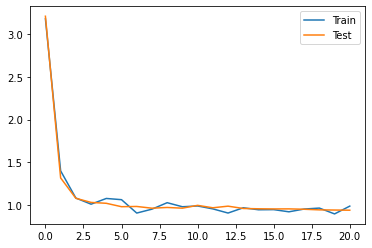

In [54]:
plt.plot(train_losses, label = 'Train')
plt.plot(test_losses, label = 'Test')
plt.legend()
plt.show()

|                    | RMSE   | Converge time (epochs) | Note                      |
|--------------------|--------|------------------------|---------------------------|
| base               | 0.9450 | 3                      |                           |
| base+bias          | 0.9374 | 3                      | Expect better performance |

# Discussion and Improvements


There are many potential improvements.

- Cross-features not considered.

- The user's watch-history embedding is calculated by taking the mean of most recent movies' embeddings. There are some issues with it:  
    - User's rating for previously watched movies is not taken into account. A negative rating may have negative effect.
    - Highly similar movies should have stronger effect than others. In reality, one may like a movie just because he/she watched a very similir movie. The attension mechanism can be applied.
    - More recent watch may matters more, too. It's possible that one would like to change a flavor after watching an action movie.

- User-Movie cross contrastive loss should be useful. (It's actually equivalent to the batch softmax optimization mentioned in the paper) However, it's not clear yet how can it applied to a regression problem.

- Avaiable information not used:
    - Movie titles are ignored. Titles can be feed into transformer and provides additional information.

- Dataset limitations:
    - User connections, such as friends, may influence.
    - User may have favorite movie actors or directors.
    
In practice,  
- Cold start problem. New users and new movies do not have accurate embeddings associated with. Data augmentation or Contrastive Learning may helps. If the history is empty, a zero tensor is not providing any information. It's even harder.
